In [4]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [5]:
DATA_DIR =  "/kaggle/input/datasets/kabil007/lungcancer4types-imagedataset/Data"

TRAIN_DIR = os.path.join(DATA_DIR, "train")
VAL_DIR   = os.path.join(DATA_DIR, "valid")
TEST_DIR  = os.path.join(DATA_DIR, "test")


In [6]:
def print_class_distribution(folder, split_name):
    dataset = datasets.ImageFolder(folder)
    counts = Counter(dataset.targets)
    print(f"\n{split_name} distribution:")
    for idx, cls in enumerate(dataset.classes):
        print(f"{cls}: {counts[idx]}")

print_class_distribution(TRAIN_DIR, "Train")
print_class_distribution(VAL_DIR, "Validation")
print_class_distribution(TEST_DIR, "Test")



Train distribution:
adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib: 195
large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa: 115
normal: 148
squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa: 155

Validation distribution:
adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib: 23
large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa: 21
normal: 13
squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa: 15

Test distribution:
adenocarcinoma: 120
large.cell.carcinoma: 51
normal: 54
squamous.cell.carcinoma: 90


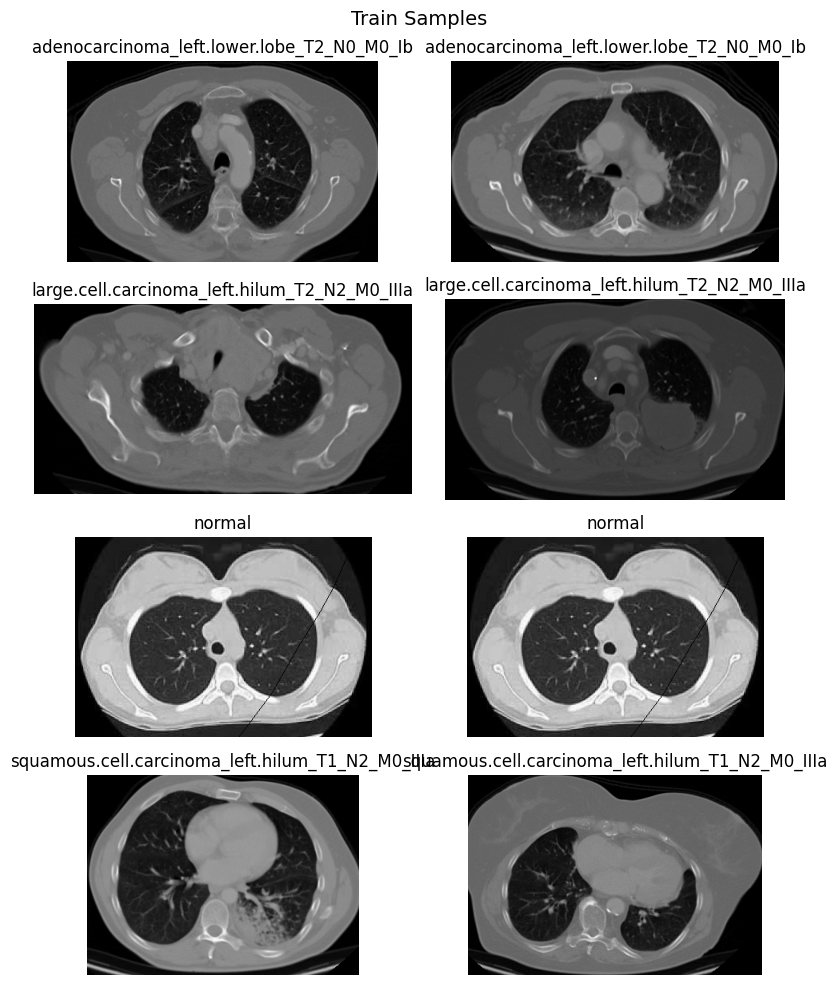

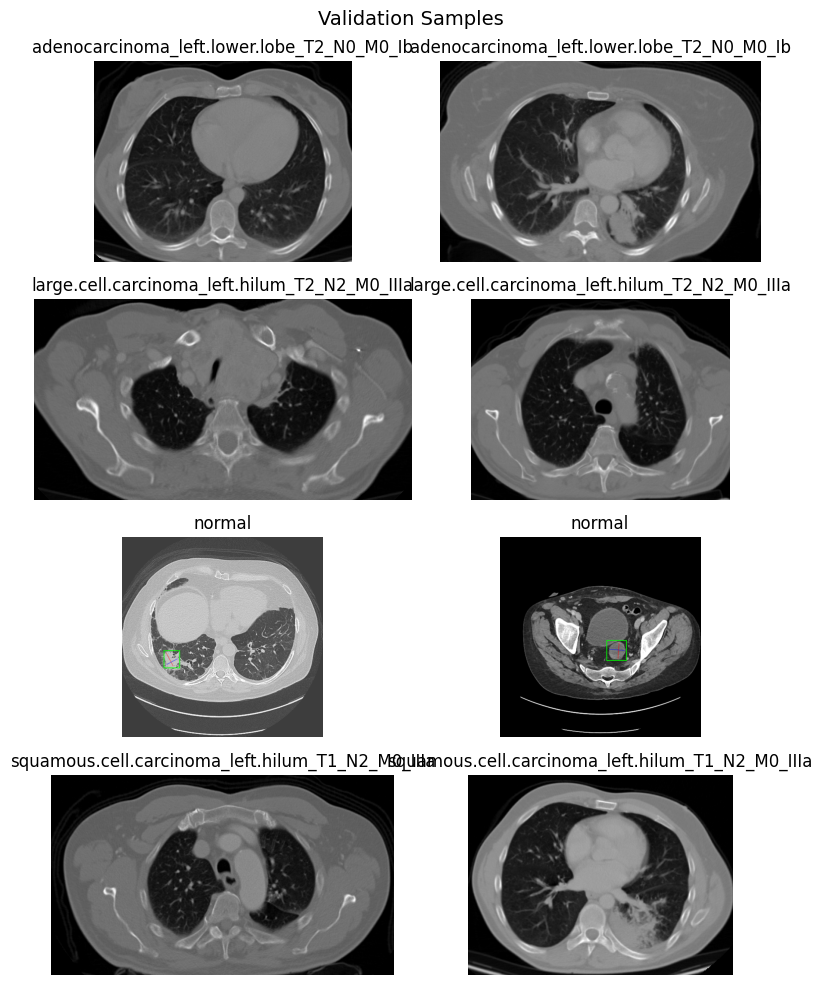

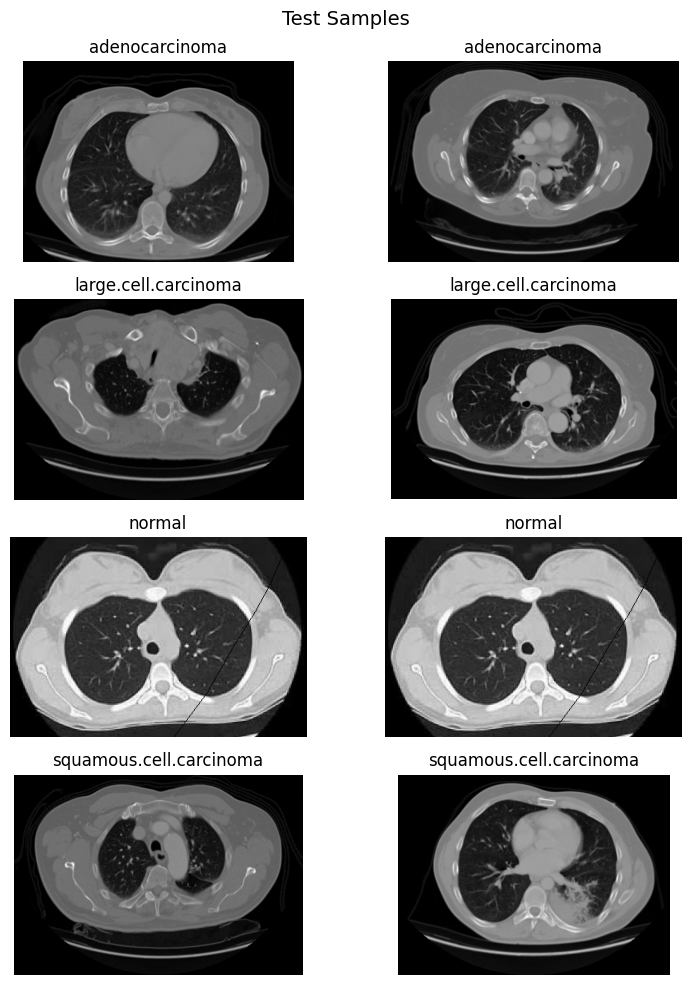

In [7]:
def show_images(folder, title, n_per_class=2):
    dataset = datasets.ImageFolder(folder)
    class_indices = {i: [] for i in range(len(dataset.classes))}

    for idx, (_, label) in enumerate(dataset):
        if len(class_indices[label]) < n_per_class:
            class_indices[label].append(idx)

    images = []
    labels = []

    for label, idxs in class_indices.items():
        for idx in idxs:
            img, lbl = dataset[idx]
            images.append(img)
            labels.append(dataset.classes[lbl])

    fig, axes = plt.subplots(len(dataset.classes), n_per_class, figsize=(8, 10))
    fig.suptitle(title, fontsize=14)

    for i in range(len(images)):
        ax = axes[i // n_per_class, i % n_per_class]
        ax.imshow(images[i])
        ax.set_title(labels[i])
        ax.axis("off")

    plt.tight_layout()
    plt.show()

show_images(TRAIN_DIR, "Train Samples")
show_images(VAL_DIR, "Validation Samples")
show_images(TEST_DIR, "Test Samples")


In [8]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),

    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])


In [9]:
train_ds = datasets.ImageFolder(TRAIN_DIR, transform=train_transform)
val_ds   = datasets.ImageFolder(VAL_DIR, transform=val_test_transform)
test_ds  = datasets.ImageFolder(TEST_DIR, transform=val_test_transform)

BATCH_SIZE = 6

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_loader  = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

NUM_CLASSES = len(train_ds.classes)
print("Classes:", train_ds.classes)


Classes: ['adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib', 'large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa', 'normal', 'squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa']


In [10]:
from torchvision import models
import torch.nn as nn

model = models.mobilenet_v2(weights="IMAGENET1K_V1")

# Replace classifier
model.classifier[1] = nn.Linear(
    model.classifier[1].in_features,
    NUM_CLASSES
)

model = model.to(device)


Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


100%|██████████| 13.6M/13.6M [00:00<00:00, 170MB/s]


In [11]:
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(
    model.parameters(),
    lr=2e-4
)


In [12]:
class EarlyStopping:
    def __init__(self, patience=5):
        self.patience = patience
        self.counter = 0
        self.best_loss = float("inf")
        self.stop = False

    def __call__(self, val_loss):
        if val_loss < self.best_loss:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.stop = True


In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_auc_score,
    matthews_corrcoef
)

from tqdm import tqdm


In [14]:
def compute_metrics(y_true, y_pred, y_prob, num_classes):
    metrics = {}

    metrics["accuracy"] = accuracy_score(y_true, y_pred)
    metrics["precision"] = precision_score(y_true, y_pred, average="macro", zero_division=0)
    metrics["recall"] = recall_score(y_true, y_pred, average="macro", zero_division=0)
    metrics["f1"] = f1_score(y_true, y_pred, average="macro", zero_division=0)
    metrics["mcc"] = matthews_corrcoef(y_true, y_pred)

    # Sensitivity = Recall
    metrics["sensitivity"] = metrics["recall"]

    # Specificity (macro)
    cm = confusion_matrix(y_true, y_pred)
    specificity = []
    for i in range(num_classes):
        tn = cm.sum() - (cm[i, :].sum() + cm[:, i].sum() - cm[i, i])
        fp = cm[:, i].sum() - cm[i, i]
        specificity.append(tn / (tn + fp + 1e-8))
    metrics["specificity"] = np.mean(specificity)

    # AUC
    try:
        metrics["auc"] = roc_auc_score(
            y_true, y_prob, multi_class="ovr"
        )
    except:
        metrics["auc"] = 0.0

    return metrics


In [15]:
def run_epoch(model, loader, criterion, optimizer=None, train=True):
    if train:
        model.train()
    else:
        model.eval()

    total_loss = 0
    all_preds, all_labels, all_probs = [], [], []

    loop = tqdm(loader)

    for images, labels in loop:
        images, labels = images.to(device), labels.to(device)

        if train:
            optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)

        if train:
            loss.backward()
            optimizer.step()

        probs = torch.softmax(outputs, dim=1)

        preds = torch.argmax(probs, dim=1)

        total_loss += loss.item()
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs.detach().cpu().numpy())

    avg_loss = total_loss / len(loader)
    return avg_loss, np.array(all_labels), np.array(all_preds), np.array(all_probs)


In [16]:
EPOCHS = 25
PATIENCE = 5

history = {
    "train": {k: [] for k in ["loss","accuracy","precision","recall","f1","specificity","sensitivity","mcc","auc"]},
    "val":   {k: [] for k in ["loss","accuracy","precision","recall","f1","specificity","sensitivity","mcc","auc"]}
}

best_val_loss = float("inf")
patience_counter = 0

for epoch in range(EPOCHS):


    train_loss, y_t, y_p, y_prob = run_epoch(
        model, train_loader, criterion, optimizer, train=True
    )
    train_metrics = compute_metrics(y_t, y_p, y_prob, NUM_CLASSES)
    train_metrics["loss"] = train_loss


    val_loss, y_t, y_p, y_prob = run_epoch(
        model, val_loader, criterion, train=False
    )
    val_metrics = compute_metrics(y_t, y_p, y_prob, NUM_CLASSES)
    val_metrics["loss"] = val_loss


    for k in history["train"]:
        history["train"][k].append(train_metrics[k])
        history["val"][k].append(val_metrics[k])


    print(f"\nTraining Model - Epoch [{epoch+1}/{EPOCHS}]")
    print(
        f"Train Metrics - loss: {train_metrics['loss']:.4f}, "
        f"accuracy: {train_metrics['accuracy']:.4f}, "
        f"precision: {train_metrics['precision']:.4f}, "
        f"recall: {train_metrics['recall']:.4f}, "
        f"f1_score: {train_metrics['f1']:.4f}, "
        f"specificity: {train_metrics['specificity']:.4f}, "
        f"sensitivity: {train_metrics['sensitivity']:.4f}, "
        f"mcc: {train_metrics['mcc']:.4f}, "
        f"auc: {train_metrics['auc']:.4f}"
    )

    print(f"Validating Model - Epoch [{epoch+1}/{EPOCHS}]")
    print(
        f"Val Metrics   - loss: {val_metrics['loss']:.4f}, "
        f"accuracy: {val_metrics['accuracy']:.4f}, "
        f"precision: {val_metrics['precision']:.4f}, "
        f"recall: {val_metrics['recall']:.4f}, "
        f"f1_score: {val_metrics['f1']:.4f}, "
        f"specificity: {val_metrics['specificity']:.4f}, "
        f"sensitivity: {val_metrics['sensitivity']:.4f}, "
        f"mcc: {val_metrics['mcc']:.4f}, "
        f"auc: {val_metrics['auc']:.4f}"
    )

    # -------- EARLY STOPPING --------
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= PATIENCE:
            print("\nEarly stopping triggered")
            break


100%|██████████| 12/12 [00:00<00:00, 31.90it/s]



Training Model - Epoch [1/25]
Train Metrics - loss: 0.7396, accuracy: 0.7210, precision: 0.7329, recall: 0.7155, f1_score: 0.7189, specificity: 0.9038, sensitivity: 0.7155, mcc: 0.6232, auc: 0.8925
Validating Model - Epoch [1/25]
Val Metrics   - loss: 0.6599, accuracy: 0.7639, precision: 0.8171, recall: 0.7906, f1_score: 0.7724, specificity: 0.9221, sensitivity: 0.7906, mcc: 0.7064, auc: 0.9516


100%|██████████| 12/12 [00:00<00:00, 30.63it/s]



Training Model - Epoch [2/25]
Train Metrics - loss: 0.3762, accuracy: 0.8564, precision: 0.8615, recall: 0.8556, f1_score: 0.8583, specificity: 0.9506, sensitivity: 0.8556, mcc: 0.8061, auc: 0.9745
Validating Model - Epoch [2/25]
Val Metrics   - loss: 0.4590, accuracy: 0.8056, precision: 0.8375, recall: 0.8306, f1_score: 0.8187, specificity: 0.9348, sensitivity: 0.8306, mcc: 0.7498, auc: 0.9735


100%|██████████| 12/12 [00:00<00:00, 34.52it/s]



Training Model - Epoch [3/25]
Train Metrics - loss: 0.2232, accuracy: 0.9331, precision: 0.9359, recall: 0.9350, f1_score: 0.9354, specificity: 0.9770, sensitivity: 0.9350, mcc: 0.9098, auc: 0.9915
Validating Model - Epoch [3/25]
Val Metrics   - loss: 0.7469, accuracy: 0.7500, precision: 0.8308, recall: 0.7871, f1_score: 0.7676, specificity: 0.9198, sensitivity: 0.7871, mcc: 0.7036, auc: 0.9716


100%|██████████| 12/12 [00:00<00:00, 31.16it/s]



Training Model - Epoch [4/25]
Train Metrics - loss: 0.2175, accuracy: 0.9282, precision: 0.9306, recall: 0.9312, f1_score: 0.9309, specificity: 0.9755, sensitivity: 0.9312, mcc: 0.9032, auc: 0.9913
Validating Model - Epoch [4/25]
Val Metrics   - loss: 0.2755, accuracy: 0.8889, precision: 0.9028, recall: 0.9031, f1_score: 0.8986, specificity: 0.9620, sensitivity: 0.9031, mcc: 0.8527, auc: 0.9908


100%|██████████| 12/12 [00:00<00:00, 31.68it/s]



Training Model - Epoch [5/25]
Train Metrics - loss: 0.1940, accuracy: 0.9445, precision: 0.9468, recall: 0.9445, f1_score: 0.9454, specificity: 0.9809, sensitivity: 0.9445, mcc: 0.9253, auc: 0.9920
Validating Model - Epoch [5/25]
Val Metrics   - loss: 0.3677, accuracy: 0.9028, precision: 0.9205, recall: 0.9041, f1_score: 0.9013, specificity: 0.9693, sensitivity: 0.9041, mcc: 0.8766, auc: 0.9866


100%|██████████| 12/12 [00:00<00:00, 33.51it/s]



Training Model - Epoch [6/25]
Train Metrics - loss: 0.1345, accuracy: 0.9690, precision: 0.9701, recall: 0.9692, f1_score: 0.9696, specificity: 0.9893, sensitivity: 0.9692, mcc: 0.9582, auc: 0.9963
Validating Model - Epoch [6/25]
Val Metrics   - loss: 0.5896, accuracy: 0.8611, precision: 0.9000, recall: 0.8715, f1_score: 0.8669, specificity: 0.9561, sensitivity: 0.8715, mcc: 0.8289, auc: 0.9683


100%|██████████| 12/12 [00:00<00:00, 31.96it/s]



Training Model - Epoch [7/25]
Train Metrics - loss: 0.1676, accuracy: 0.9429, precision: 0.9447, recall: 0.9456, f1_score: 0.9450, specificity: 0.9805, sensitivity: 0.9456, mcc: 0.9232, auc: 0.9935
Validating Model - Epoch [7/25]
Val Metrics   - loss: 0.3360, accuracy: 0.8750, precision: 0.8891, recall: 0.8765, f1_score: 0.8764, specificity: 0.9586, sensitivity: 0.8765, mcc: 0.8348, auc: 0.9831


100%|██████████| 12/12 [00:00<00:00, 32.94it/s]



Training Model - Epoch [8/25]
Train Metrics - loss: 0.1890, accuracy: 0.9560, precision: 0.9567, recall: 0.9553, f1_score: 0.9557, specificity: 0.9850, sensitivity: 0.9553, mcc: 0.9407, auc: 0.9925
Validating Model - Epoch [8/25]
Val Metrics   - loss: 0.4833, accuracy: 0.8194, precision: 0.8614, recall: 0.8404, f1_score: 0.8329, specificity: 0.9418, sensitivity: 0.8404, mcc: 0.7736, auc: 0.9812


100%|██████████| 12/12 [00:00<00:00, 32.57it/s]


Training Model - Epoch [9/25]
Train Metrics - loss: 0.1196, accuracy: 0.9690, precision: 0.9710, recall: 0.9666, f1_score: 0.9686, specificity: 0.9893, sensitivity: 0.9666, mcc: 0.9583, auc: 0.9978
Validating Model - Epoch [9/25]
Val Metrics   - loss: 0.3354, accuracy: 0.9167, precision: 0.9233, recall: 0.9175, f1_score: 0.9158, specificity: 0.9730, sensitivity: 0.9175, mcc: 0.8904, auc: 0.9842

Early stopping triggered


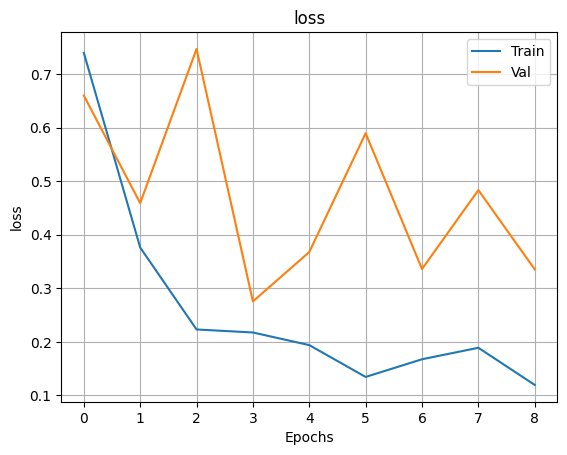

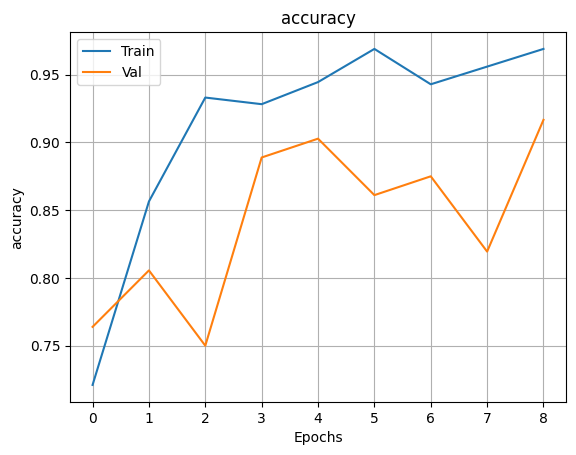

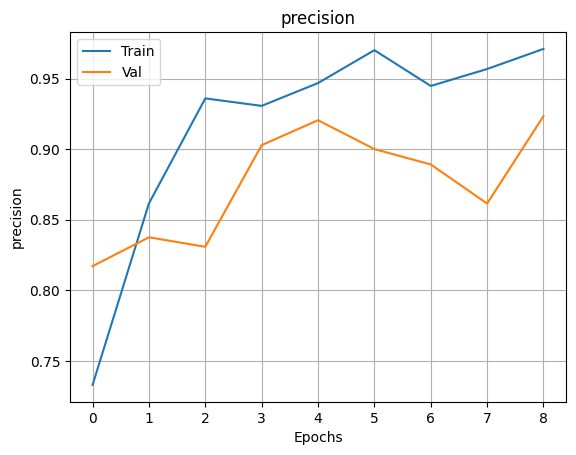

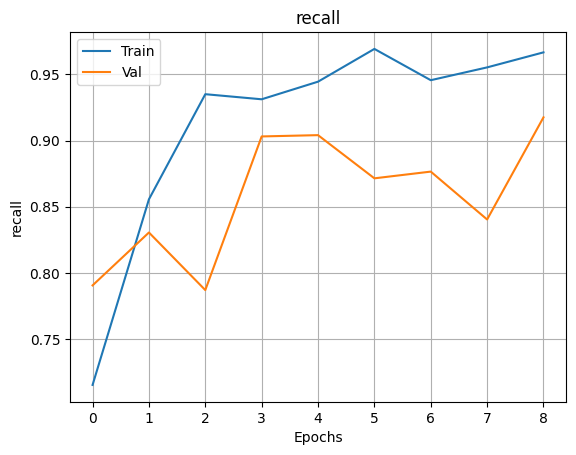

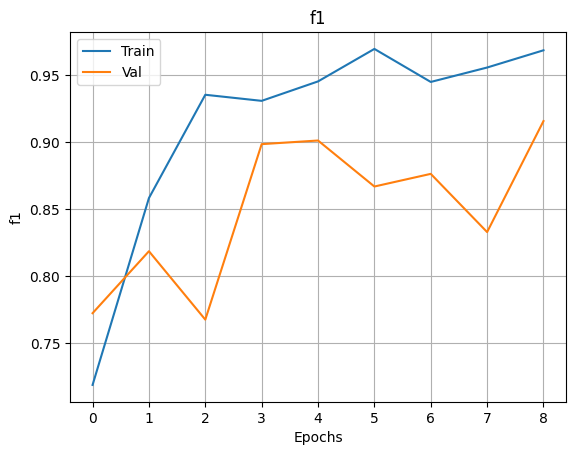

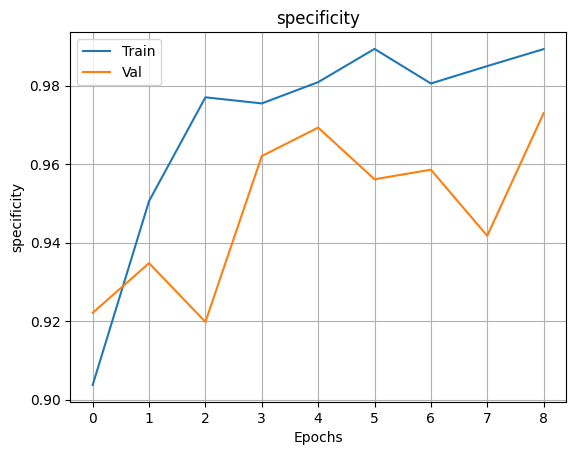

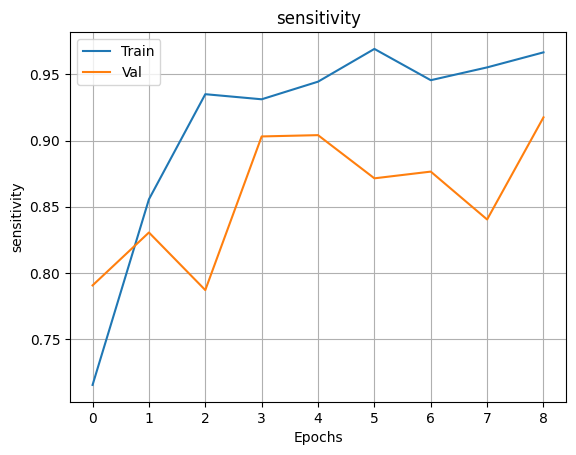

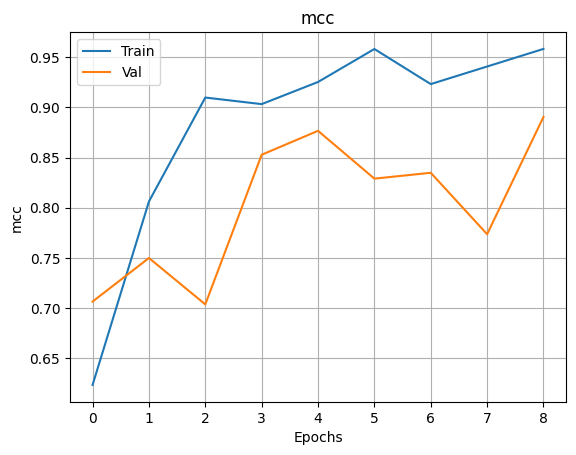

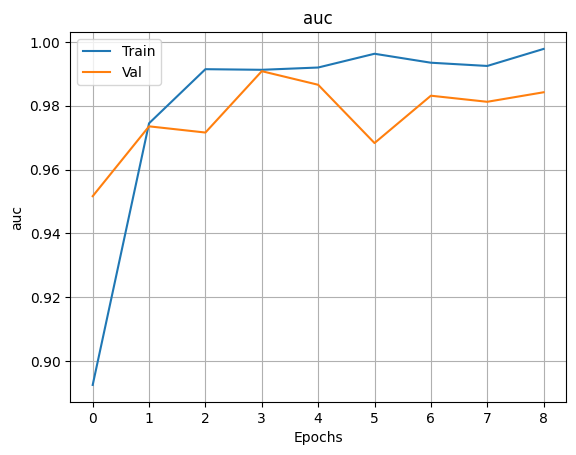

In [17]:
def plot_metric(metric):
    plt.figure()
    plt.plot(history["train"][metric], label="Train")
    plt.plot(history["val"][metric], label="Val")
    plt.title(metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend()
    plt.grid()
    plt.show()

metrics_to_plot = [
    "loss","accuracy","precision","recall","f1",
    "specificity","sensitivity","mcc","auc"
]

for m in metrics_to_plot:
    plot_metric(m)


In [18]:
model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        preds = torch.argmax(outputs, dim=1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())


cm = confusion_matrix(y_true, y_pred)
print("\nConfusion Matrix:\n", cm)


print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=train_ds.classes,digits=4))



Confusion Matrix:
 [[96 14  0 10]
 [ 0 50  0  1]
 [ 1  0 53  0]
 [ 2  3  0 85]]

Classification Report:
                                                  precision    recall  f1-score   support

      adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib     0.9697    0.8000    0.8767       120
   large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa     0.7463    0.9804    0.8475        51
                                          normal     1.0000    0.9815    0.9907        54
squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa     0.8854    0.9444    0.9140        90

                                        accuracy                         0.9016       315
                                       macro avg     0.9003    0.9266    0.9072       315
                                    weighted avg     0.9146    0.9016    0.9022       315



In [19]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(7, 6))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=class_names,
        yticklabels=class_names
    )
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix (Counts)")
    plt.tight_layout()
    plt.show()


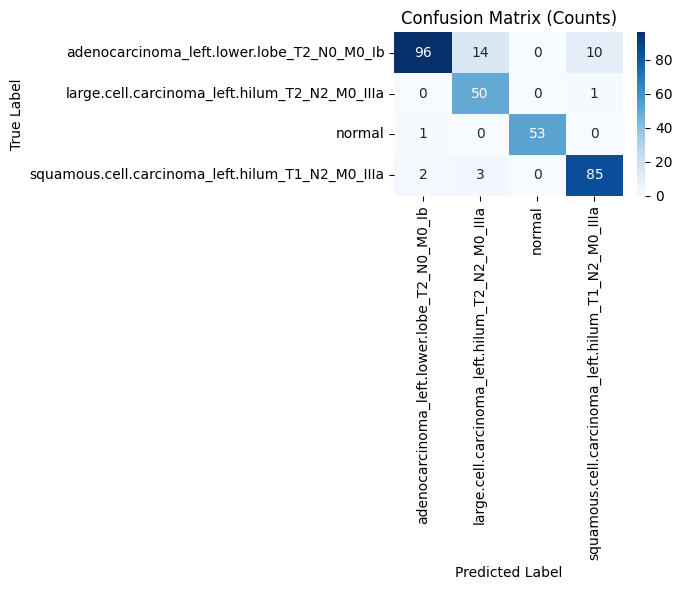

In [20]:
plot_confusion_matrix(y_true, y_pred, train_ds.classes)


In [21]:
from sklearn.preprocessing import label_binarize

model.eval()
y_true = []
y_prob = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)

        y_true.extend(labels.numpy())
        y_prob.extend(probs.cpu().numpy())

y_true = np.array(y_true)
y_prob = np.array(y_prob)

num_classes = y_prob.shape[1]
class_names = train_ds.classes


In [22]:
from sklearn.metrics import roc_curve, auc

def plot_roc_ovr(y_true, y_prob, class_names):
    y_true_bin = label_binarize(y_true, classes=range(len(class_names)))

    plt.figure(figsize=(8, 6))

    for i, cls in enumerate(class_names):
        fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_prob[:, i])
        roc_auc = auc(fpr, tpr)

        plt.plot(fpr, tpr, label=f"{cls} (AUC = {roc_auc:.3f})")

    plt.plot([0, 1], [0, 1], "k--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curves (One-vs-Rest)")
    plt.legend(loc="lower right")
    plt.grid()
    plt.tight_layout()
    plt.show()


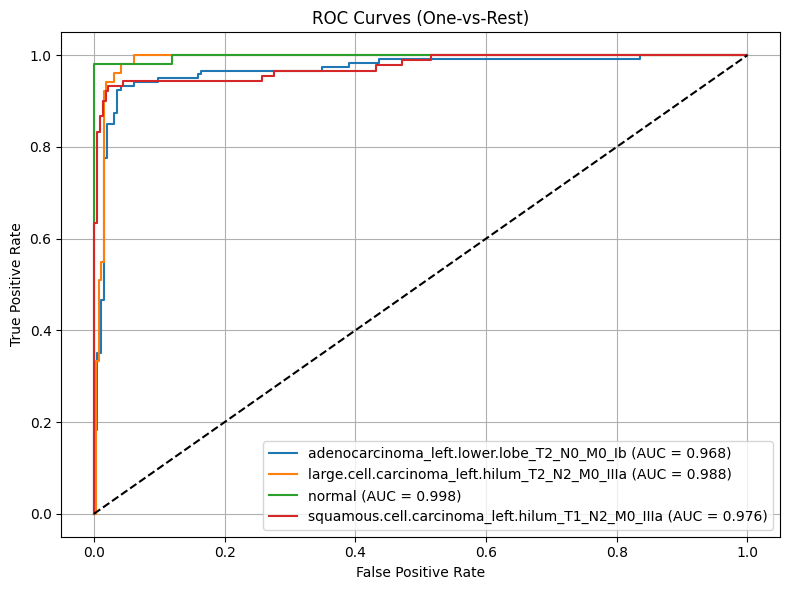

In [23]:
plot_roc_ovr(y_true, y_prob, train_ds.classes)
